In [1]:
# ipython kernel install --user --name=venv
import pandas as pd
import numpy as np
import requests
import json
from pandas import json_normalize
from functools import reduce
import matplotlib.pyplot as plt
from itables import show
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [2]:
CAMPINAS_CODE = "3509502"
SAO_PAULO_CODE = "3550308"
CAPELINHA_CODE = "3112307"
INDAIATUBA_CODE = "3520509"

In [3]:
def _get_county_pib_df(json_data):
    pib_municipios_ibge_json = json_data[0]["resultados"][0]["series"]
    pib_municipios_ibge_df = pd.json_normalize(pib_municipios_ibge_json)
    pib_municipios_ibge_df = pib_municipios_ibge_df.drop(['localidade.nivel.id', 'localidade.nivel.nome', "localidade.nome"], axis=1)
    return pib_municipios_ibge_df

In [4]:
# Build the table with county PIB

years = list(range(2013, 2022))
counties_pib_dfs = []

for year in years:
    print(f"Getting data for year {year}")
    county_pib_url = f"https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/{year}/variaveis/37?localidades=N6[all]"
    response = requests.get(county_pib_url)

    if response.status_code == 200:
        data = response.json()
        print("Building dataframe...")
        counties_pib_dfs.append(_get_county_pib_df(data))
    else:
        print("Request failed with status code:", response.status_code)

print("Merging dataframes...")
complete_counties_pib = reduce(lambda df1,df2: pd.merge(df1,df2,on='localidade.id', how='outer'), counties_pib_dfs)

new_column_names = {'serie.{}'.format(year): 'pib_{}'.format(year) for year in years}
new_column_names["localidade.id"] = "county_id"
complete_counties_pib = complete_counties_pib.rename(columns=new_column_names)

print("Finished building the table with county PIB")

Getting data for year 2013
Building dataframe...
Getting data for year 2014
Building dataframe...
Getting data for year 2015
Building dataframe...
Getting data for year 2016
Building dataframe...
Getting data for year 2017
Building dataframe...
Getting data for year 2018
Building dataframe...
Getting data for year 2019
Building dataframe...
Getting data for year 2020
Building dataframe...
Getting data for year 2021
Building dataframe...
Merging dataframes...
Finished building the table with county PIB


In [5]:
display(complete_counties_pib)

,county_id,pib_2013,pib_2014,pib_2015,pib_2016,pib_2017,pib_2018,pib_2019,pib_2020,pib_2021
0,1100015,341325,377799,421300,478217,485374,498980,495775,570242,734469
1,1100023,1799853,1921532,2037799,2184346,2287910,2464704,2579278,2817331,3209761
2,1100031,96365,113477,116565,133342,138110,140503,139976,167153,238412
3,1100049,1433254,1660650,1794478,1947283,2082761,2175840,2261930,2518845,2792383
4,1100056,353270,392417,397736,408194,439245,470647,506494,600630,743037
...,...,...,...,...,...,...,...,...,...,...
5565,5222005,291919,302880,312348,373802,395861,449973,489265,559058,857968
5566,5222054,259422,275800,322298,351750,350839,339089,326519,419757,480173
5567,5222203,103233,90478,111229,138810,118639,108469,112209,126150,179899
5568,5222302,142970,138474,198935,210475,182203,179915,207994,217935,308013


In [6]:
display(complete_counties_pib[complete_counties_pib['county_id'] == SAO_PAULO_CODE])

,county_id,pib_2013,pib_2014,pib_2015,pib_2016,pib_2017,pib_2018,pib_2019,pib_2020,pib_2021
3829,3550308,582079726,621917372,653646991,683066697,698952189,714663604,763597808,746909330,828980608


# Dados do INEP

_O conceito técnico de abandono é diferente de evasão. Abandono quer dizer que o aluno deixa a escola num ano mas retorna no ano seguinte. Evasão significa que o aluno sai da escola e não volta mais para o sistema._

In [ ]:
inep_data = pd.read_csv("master_data_2021_v2.csv", delimiter=";") 

# inep_data = pd.read_excel("master_data_2021.xlsx")
# display(inep_data)

filtered_data = inep_data[(inep_data['NO_CATEGORIA'] == 'Total') & (inep_data['NO_DEPENDENCIA'] == 'Total')]
drop_columns = ["ED_BAS_CAT1",	"ED_BAS_CAT2",	"ED_BAS_CAT3",	"ED_BAS_CAT4",	"ED_BAS_CAT5",	"ED_BAS_CAT6",	"ED_BAS_CAT7",	"ED_BAS_CAT8",	"ED_BAS_CAT9"]
filtered_data = filtered_data.drop(drop_columns, axis=1)


# display(filtered_data)

In [ ]:
# Crie um DataFrame com as informações das features e a quantidade de dados faltantes
df_missing = pd.DataFrame({'Feature': filtered_data.columns, 'Missing': filtered_data.isnull().sum()})
df_missing['Percentage'] = (df_missing['Missing'] / len(filtered_data)) * 100

# Ordene o DataFrame pela porcentagem de dados faltantes em ordem decrescente
df_missing = df_missing.sort_values('Percentage', ascending=False)

# display(df_missing)

# Crie o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(df_missing['Feature'], df_missing['Percentage'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data by Feature')
plt.show()


In [65]:
display(filtered_data.dtypes)
column_types = filtered_data.dtypes.value_counts()
print(column_types)


NU_ANO_CENSO           int64
CO_MUNICIPIO           int64
NO_CATEGORIA          object
NO_DEPENDENCIA        object
ED_INF_CAT_1         float64
                      ...   
1_CAT1_CATMED        float64
1_CAT2_CATFUN        float64
1_CAT2_CATMED        float64
EVASAO_COLUMN_FUN    float64
EVASAO_COLUMN_MED    float64
Length: 75, dtype: object

float64    38
object     35
int64       2
Name: count, dtype: int64


In [52]:
ABANDONO_COLUMN_FUN = "3_CAT_FUN"
ABANDONO_COLUMN_MED ="3_CAT_MED"
EVASAO_COLUMN_FUN = "1_CAT3_CATFUN"
EVASAO_COLUMN_MED = "1_CAT3_CATMED"

In [55]:
colunas_interesse = ["ABANDONO_COLUMN_FUN", "ABANDONO_COLUMN_MED", "EVASAO_COLUMN_FUN", "EVASAO_COLUMN_MED"]

filtered_data.rename(columns={
    '3_CAT_FUN': 'ABANDONO_COLUMN_FUN', 
    '3_CAT_MED': 'ABANDONO_COLUMN_MED', 
    '1_CAT3_CATFUN': 'EVASAO_COLUMN_FUN', 
    '1_CAT3_CATMED': 'EVASAO_COLUMN_MED'
    }, inplace=True)

for column in colunas_interesse:
    filtered_data[column] = filtered_data[column].astype(float)

In [ ]:

# Colunas de interesse
colunas_interesse = ["ABANDONO_COLUMN_FUN", "ABANDONO_COLUMN_MED", "EVASAO_COLUMN_FUN", "EVASAO_COLUMN_MED"]

for column in colunas_interesse:
    print(f'Coluna: {column}')
    print("Mean: ", filtered_data[column].mean())
    print("Std: ", filtered_data[column].std())
    print("Mode: ", filtered_data[column].mode())
    print("Max: ", filtered_data[column].max())
    print("Min: ", filtered_data[column].min())
    print("===============================")


In [ ]:
show(filtered_data[["CO_MUNICIPIO", "ABANDONO_COLUMN_MED", "EVASAO_COLUMN_MED"]])


In [ ]:
display(filtered_data.query(f"ABANDONO_COLUMN_MED > EVASAO_COLUMN_MED"))

In [81]:
trainning_df = filtered_data.drop(["NU_ANO_CENSO","CO_MUNICIPIO","NO_CATEGORIA","NO_DEPENDENCIA","NO_REGIAO", "NO_UF"], axis=1)
display(trainning_df)


label_encoder = LabelEncoder()
x_categorical = trainning_df.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = trainning_df.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values


,ED_INF_CAT_1,ED_INF_CAT_2,ED_INF_CAT_3,ED_INF_CAT_4,ED_INF_CAT_5,ED_INF_CAT_0,EDU_BAS_CAT_5,EDU_BAS_CAT_6,FUN_CAT_1,FUN_CAT_2,...,2_CAT_MED,ABANDONO_COLUMN_FUN,ABANDONO_COLUMN_MED,NO_MUNICIPIO,1_CAT1_CATFUN,1_CAT1_CATMED,1_CAT2_CATFUN,1_CAT2_CATMED,EVASAO_COLUMN_FUN,EVASAO_COLUMN_MED
0,66.2,0.0,20.4,0.0,13.4,15.0,0.0,0.0,27.6,7.6,...,0.5,0.3,0.5,Adamantina,99.7,95.8,0.1,1.4,0.2,0.6
2,74.1,0.0,25.9,0.0,0.0,13.0,0.0,0.0,33.3,12.8,...,0.0,0.0,2.2,Adolfo,98.4,97.0,1.0,0.8,0.6,2.2
4,90.1,0.0,8.9,0.0,1.0,15.9,0.0,7.7,28.6,5.6,...,2.3,0.1,4.8,Aguaí,98.9,95.3,0.5,1.6,0.4,0.9
6,54.8,0.0,41.9,0.0,3.3,17.2,0.0,0.0,26.9,15.4,...,9.2,1.1,6.3,Águas da Prata,99.4,97.5,0.2,0.8,0.4,1.7
8,91.9,0.0,5.9,0.7,1.5,13.0,5.3,5.1,18.5,8.6,...,2.4,0.1,1.0,Águas de Lindóia,91.8,91.4,6.0,5.1,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,49.7,0.0,21.8,0.8,27.7,18.9,2.4,1.2,14.7,26.3,...,0.9,0.4,2.5,Votorantim,99.1,95.8,0.3,1.4,0.4,2.3
1282,65.2,0.0,32.6,0.0,2.2,18.2,0.0,1.6,16.5,17.7,...,1.2,0.1,0.4,Votuporanga,98.8,96.0,0.7,1.5,0.5,2.3
1284,90.0,0.0,0.0,0.0,10.0,9.4,33.3,0.0,26.0,7.4,...,0.0,0.0,0.0,Zacarias,99.1,100.0,0.0,0.0,0.9,0.0
1286,41.4,0.0,55.7,0.0,2.9,17.5,8.3,0.0,17.0,6.4,...,0.6,0.4,4.1,Chavantes,99.1,88.3,0.3,5.5,0.5,2.6


In [82]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

y = trainning_df["EVASAO_COLUMN_MED"].values  # Target variable
# Fit the regressor with x and y data
regressor.fit(x_numerical, y)


/home/cristiano/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [83]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(x_numerical)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.9728282370425053
Mean Squared Error: 0.0038894573643410936
R-squared: 0.9991836272809209


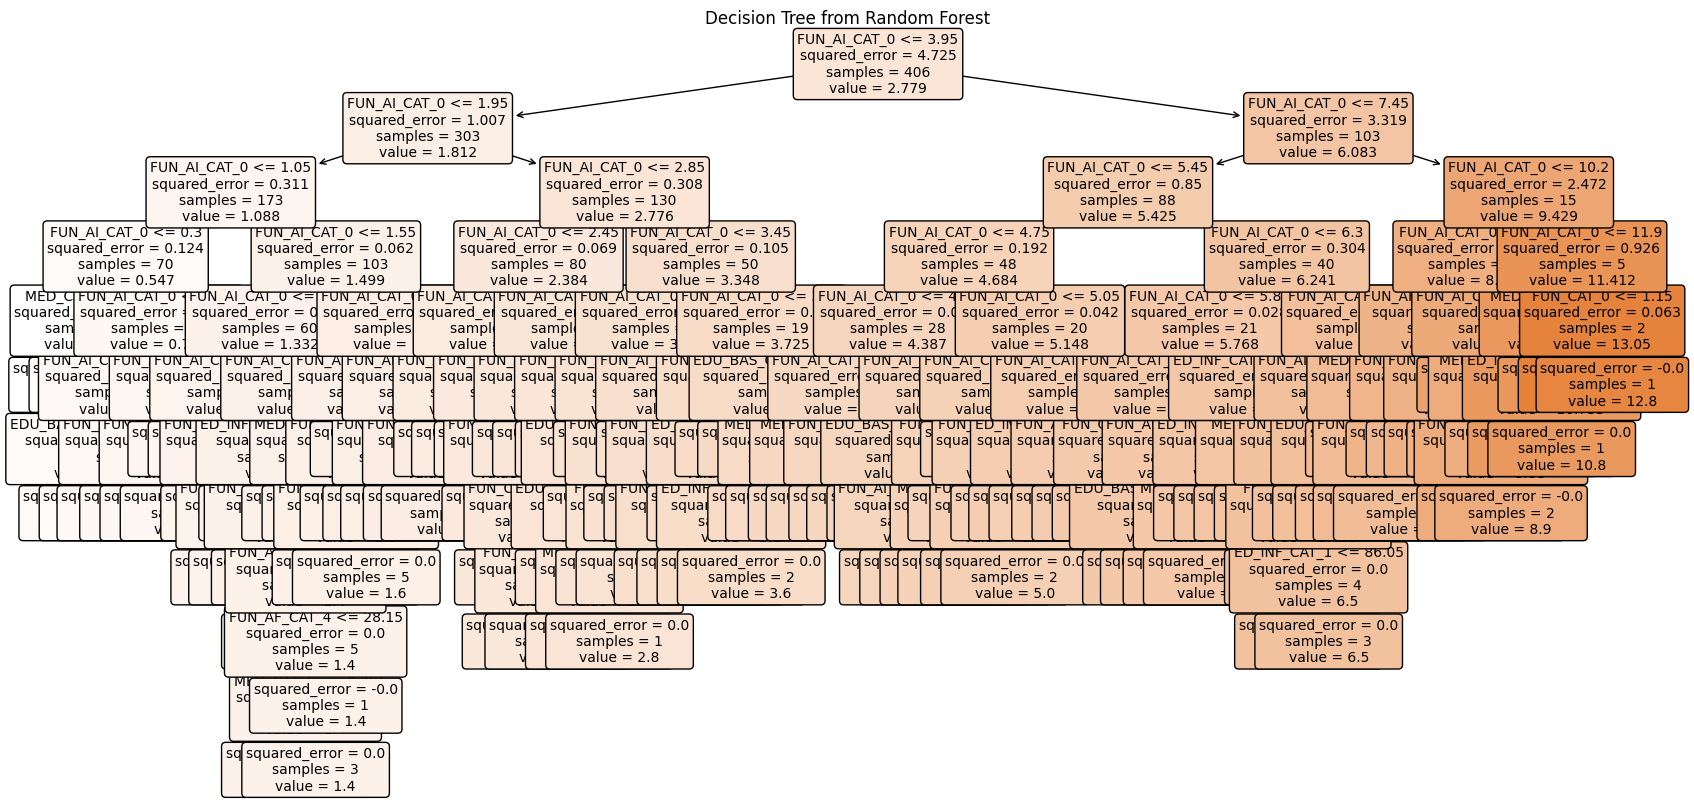

In [86]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
 
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = regressor.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()